In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rcParams
import math
from utils.utils import *
from dtw import dtw


np.random.seed(2)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# Set device
print(f'The device used in this notebook is: {setDevice()}')

DEVICE = setDevice()

The device used in this notebook is: cuda


#### Import data

In [3]:
# Set settings
features, input_window, output_window, stride = set_settings()

print(f'features: {features}')
print(f'input_window: {input_window}')
print(f'output_window: {output_window}')
print(f'stride: {stride}')

features: ['Hips Flexion-Extension Left', 'Knees Flexion-Extension Left', 'Ankles Dorsiflexion-Plantarflexion Left', 'Hips Flexion-Extension Right', 'Knees Flexion-Extension Right', 'Ankles Dorsiflexion-Plantarflexion Right']
input_window: 100
output_window: 1
stride: 1


In [41]:
file_dir = r'D:\Study 2 Data\sample_combined_data' # Location of Healthy Gait Data
# file_dir = r'D:\Study 2 Data\sample_CP_data' #Location of CP Gait Data

train_files = os.listdir(file_dir) 

# Changes the working directory to get the data from their location 
os.chdir(file_dir)
cwd = os.getcwd()

print(f'Current working directory is: {cwd}')
print(f"There are {len(train_files)} files in the specified path.")

Current working directory is: D:\Study 2 Data\sample_combined_data
There are 5 files in the specified path.


In [42]:
train_files

['AB2188 BF T1-5.csv',
 'AB3154 BF T6-10.csv',
 'AB9738 BF T1-5.csv',
 'RP9534 V2 BF T1-5.csv',
 'RP9571 V1 BF T6-10.csv']

In [43]:
#Create feature list to extract values needed from CSV files
all_features = ['Trial', 'Time'] + features
all_features


['Trial',
 'Time',
 'Hips Flexion-Extension Left',
 'Knees Flexion-Extension Left',
 'Ankles Dorsiflexion-Plantarflexion Left',
 'Hips Flexion-Extension Right',
 'Knees Flexion-Extension Right',
 'Ankles Dorsiflexion-Plantarflexion Right']

In [44]:
all_data = create_dataframe(train_files, all_features)

Extracting data from: AB2188 BF T1-5.csv
Extracting data from: AB3154 BF T6-10.csv
Extracting data from: AB9738 BF T1-5.csv
Extracting data from: RP9534 V2 BF T1-5.csv
Extracting data from: RP9571 V1 BF T6-10.csv


In [45]:
all_data.reset_index(drop=True, inplace=True) #reset the index of the table
# path = r'D:\Study 2 Data\Healthy Gait' + '\\' + 'all_data_healthy_train.csv'
# all_data.to_csv(path)

In [46]:
all_data

,Patient ID,Trial,Time,Hips Flexion-Extension Left,Knees Flexion-Extension Left,Ankles Dorsiflexion-Plantarflexion Left,Hips Flexion-Extension Right,Knees Flexion-Extension Right,Ankles Dorsiflexion-Plantarflexion Right
0,AB2188 BF T1-5,1.0,223.83,24.69730,43.98116,13.16722,7.40105,19.83552,3.46198
1,AB2188 BF T1-5,1.0,223.84,24.44713,43.17039,13.07729,7.04358,19.57988,3.53245
2,AB2188 BF T1-5,1.0,223.85,24.17547,42.45852,13.01625,6.69202,19.29897,3.58736
3,AB2188 BF T1-5,1.0,223.86,23.88122,41.82635,12.98980,6.35465,19.00309,3.63057
4,AB2188 BF T1-5,1.0,223.87,23.56337,41.25273,13.00300,6.03926,18.70273,3.66602
...,...,...,...,...,...,...,...,...,...
41795,RP9571 V1 BF T6-10,12.0,455.37,26.16216,58.23023,-10.65388,6.83396,14.26478,13.34809
41796,RP9571 V1 BF T6-10,12.0,455.38,26.97031,57.93254,-10.72319,6.76816,13.95214,13.11397
41797,RP9571 V1 BF T6-10,12.0,455.39,27.66762,57.48811,-10.87114,6.74098,13.78196,12.93566
41798,RP9571 V1 BF T6-10,12.0,455.40,28.24632,56.88607,-11.09041,6.74995,13.74926,12.81175


In [47]:
n_trials = all_data['Trial'].max()
print(f'maximum number of trials is: {n_trials}')

maximum number of trials is: 12.0


In [48]:
all_data['Patient ID'].unique()

array(['AB2188 BF T1-5', 'AB3154 BF T6-10', 'AB9738 BF T1-5',
       'RP9534 V2 BF T1-5', 'RP9571 V1 BF T6-10'], dtype=object)

In [49]:
# Healthy Subjects 
train_subjects = ['AB2188 BF T1-5',]

val_subjects=['AB3154 BF T6-10',]

test_subjects = ['AB9738 BF T1-5',]       

CP_subjects = [ 'RP9534 V2 BF T1-5',
                'RP9571 V1 BF T6-10',]

In [50]:
val_subjects

['AB3154 BF T6-10']

In [51]:
train_data = all_data.loc[all_data['Patient ID'].isin(train_subjects)]

val_data = all_data.loc[all_data['Patient ID'].isin(val_subjects)]

test_data = all_data.loc[all_data['Patient ID'].isin(test_subjects)]

CP_data = all_data.loc[all_data['Patient ID'].isin(CP_subjects)]

In [52]:
print(f'all_data: {all_data.shape}')
print(f'train_data: {train_data.shape}')
print(f'val_data: {val_data.shape}')
print(f'test_data: {test_data.shape}')
print(f'CP_data: {CP_data.shape}')

all_data: (41800, 9)
train_data: (7262, 9)
val_data: (6507, 9)
test_data: (8432, 9)
CP_data: (19599, 9)


In [53]:
train_samples = count_nsamples(train_data)
val_samples = count_nsamples(val_data)
test_samples = count_nsamples(test_data)
CP_samples = count_nsamples(CP_data)

For patient: AB2188 BF T1-5, trial: 1.0, there are: 718 time-points
For patient: AB2188 BF T1-5, trial: 2.0, there are: 801 time-points
For patient: AB2188 BF T1-5, trial: 3.0, there are: 706 time-points
For patient: AB2188 BF T1-5, trial: 4.0, there are: 651 time-points
For patient: AB2188 BF T1-5, trial: 5.0, there are: 741 time-points
For patient: AB2188 BF T1-5, trial: 6.0, there are: 691 time-points
For patient: AB2188 BF T1-5, trial: 7.0, there are: 722 time-points
For patient: AB2188 BF T1-5, trial: 8.0, there are: 726 time-points
For patient: AB2188 BF T1-5, trial: 9.0, there are: 740 time-points
For patient: AB2188 BF T1-5, trial: 10.0, there are: 766 time-points

There are 10 samples
For patient: AB3154 BF T6-10, trial: 1.0, there are: 651 time-points
For patient: AB3154 BF T6-10, trial: 2.0, there are: 541 time-points
For patient: AB3154 BF T6-10, trial: 3.0, there are: 613 time-points
For patient: AB3154 BF T6-10, trial: 4.0, there are: 601 time-points
For patient: AB3154 B

In [54]:
print(f'Number of train samples: {train_samples}')
print(f'Number of validation samples: {val_samples}')
print(f'Number of test samples: {test_samples}')
print(f'Number of CP samples: {CP_samples}')

Number of train samples: 10
Number of validation samples: 9
Number of test samples: 9
Number of CP samples: 22


In [55]:
m = all_data['Patient ID'].unique()

In [56]:
def pd_to_np_converter(data, n_samples, features):
    #create a numpy array that stores the data for export
    sample_ID = []
    # patients = 2
    # n_trials = 10
    # # samples = patients * n_trials
    data_store = np.zeros((n_samples, 2500, len(features)), dtype=np.float32)
    i = 0

    for p in data['Patient ID'].unique(): #loop over patients 
        for t in data['Trial'].unique(): #loop over trials starting with trials 1 to trial 9 (inclusive)
            pd_array = data[(data['Patient ID'] == p) & (data['Trial'] == t)]
            if pd_array.empty:
                continue
                # print('DataFrame is empty!')
                # print(f'Trail {t} does not exist in {p}')
            else:
                np_array = pd_array.to_numpy()
                data_store[i, :np_array.shape[0], :] = np_array[:,3:] 
                sample_ID.append(p+ ' Ts'+str(t)) 
                i +=1

    return pd_array.columns, data_store

In [57]:
train_columns, train_data_np = pd_to_np_converter(train_data, train_samples, features)
val_columns, val_data_np = pd_to_np_converter(val_data, val_samples, features)
test_columns, test_data_np = pd_to_np_converter(test_data, test_samples, features)
CP_columns, CP_data_np = pd_to_np_converter(CP_data, CP_samples, features)

print(f'train_data_np.shape: {train_data_np.shape}')
print(f'val_data_np.shape: {val_data_np.shape}')
print(f'test_data_np.shape: {test_data_np.shape}')
print(f'CP_data_np.shape: {CP_data_np.shape}')

train_data_np.shape: (10, 2500, 6)
val_data_np.shape: (9, 2500, 6)
test_data_np.shape: (9, 2500, 6)
CP_data_np.shape: (22, 2500, 6)


In [58]:
train_columns[3:].tolist() 

['Hips Flexion-Extension Left',
 'Knees Flexion-Extension Left',
 'Ankles Dorsiflexion-Plantarflexion Left',
 'Hips Flexion-Extension Right',
 'Knees Flexion-Extension Right',
 'Ankles Dorsiflexion-Plantarflexion Right']

In [59]:
features == train_columns[3:].tolist() 

True

In [60]:
labels_keys = train_columns[3:].tolist() #copy the train columns removing the first column headers'Patient ID', 'Trial', 'Time'


if features == labels_keys: # check that the features are the same as the label keys 
    print('YAY! Column headers of dataframe match features')
else:
    print('ERROR: Features and labels_keys do not match!')

YAY! Column headers of dataframe match features


In [61]:
labels_keys = features 

labels_idx = np.arange(0, len(labels_keys), 1)

labels = dict(zip(labels_keys, labels_idx))

len(labels)
labels
# labels_keys

{'Hips Flexion-Extension Left': 0,
 'Knees Flexion-Extension Left': 1,
 'Ankles Dorsiflexion-Plantarflexion Left': 2,
 'Hips Flexion-Extension Right': 3,
 'Knees Flexion-Extension Right': 4,
 'Ankles Dorsiflexion-Plantarflexion Right': 5}

In [62]:
def window_generator_fltrd(sequence, input_window, output_window, stride, features, labels):
    """
    Trims the input sequence from leading and trailing zeros, then generates an array with input windows and another array for the corresponding output windows
    Args:
        sequence: (np.array, float32) columns are features while rows are time points
        features: (list, strin~g) column names
        input_window: (int)
        stride (int): the value the input window shifts along the sequence 
    Returns:

    """
    # shortest_seqLen = float('inf')

    # f_zeros = [] #array that stores the number of leading zeros for each feature
    b_zeros = [] #array that stores the number of trailing zeros for each feacture 

    for f in features:
        # trim the leading and training zeros
        # f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
        b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros

    # max_f_zeros = max(f_zeros) #find the maximum number of leading zeros
    max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
    # print(max_b_zeros)

    #total sequence length minus max leading and trailing zeros 
    trimmed_seqLen = sequence[:,0].shape[0] - (max_b_zeros)
    trimmed_seqLen_reduced = trimmed_seqLen - 300 #reducing sequence size to remove the first and last 200 timesteps which may contain errors   
    print(f'trimmed_seqLen: {trimmed_seqLen}')
    print(f'trimmed_seqLen_reduced: {trimmed_seqLen_reduced}')


    # Slides are the number of times the input window can scan the sequence 
    # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
    # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
    slides = ((trimmed_seqLen_reduced - (input_window+output_window)) // stride) + 1
    print(f"number of slides is: {slides}")

    # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
    seq_indicies = (np.arange(slides) * stride) + 150

    if slides <= 0:
        raise ValueError("input window and output window length are greater than sequence length, check their values")
        

    # Creates an zero numpy array to store the samples in 
    X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
    Y_values = np.zeros((len(seq_indicies), output_window, len(features)))

    # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
    for j, feature in enumerate(features):
        # print(j)
        # print(feature)
        for i, idx in enumerate(seq_indicies):
            X_values[i, :, j] = sequence[idx:idx+input_window, labels[feature]]
            Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + output_window, labels[feature]]

    return X_values, Y_values 

In [63]:
def window_generator_lt_fltrd(sequence, input_window, future_window, stride, features, labels): #window gernerator long term fltrd (creats a validation window up to 200 timesteps in advance to measure error on long term future predictions)
    """
    Trims the input sequence from leading and trailing zeros, then generates an array with input windows and another array for the corresponding output windows
    Args:
        sequence: (np.array, float32) columns are features while rows are time points
        features: (list, strin~g) column names
        input_window: (int)
        stride (int): the value the input window shifts along the sequence 
    Returns:

    """
    b_zeros = [] #array that stores the number of trailing zeros for each feacture 

    for f in features:
        # trim the leading and training zeros
        b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros

    max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
    # print(max_b_zeros)

    fltrd_samples = 2 * 150 #remove 100 timesteps from the beggining and ending of the entire sequence
    # lt_len = 200 # number of timesteps to predict in the future based on a single input window (to be used in measuring errors based on prediction input)
    
    #total sequence length minus max leading and trailing zeros 
    trimmed_seqLen = sequence[:,0].shape[0] - (max_b_zeros)
    trimmed_seqLen_reduced = trimmed_seqLen - (fltrd_samples) # (- fltrd_samples is done to reduce sequence size to remove the first and last 150 timesteps which may contain errors since they corresponding to beggining and ending of the trials 
    print(f'trimmed_seqLen: {trimmed_seqLen}')
    print(f'trimmed_seqLen_reduced: {trimmed_seqLen_reduced}')


    # Slides are the number of times the input window can scan the sequence 
    # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
    # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
    slides = ((trimmed_seqLen_reduced - (input_window+future_window)) // stride) + 1
    print(f"number of slides is: {slides}")

    # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
    seq_indicies = (np.arange(slides) * stride) + 150

    if slides <= 0:
        raise ValueError("input window and output window length are greater than sequence length, check their values")
        # return None 

    # Creates an zero numpy array to store the samples in 
    X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
    Y_values = np.zeros((len(seq_indicies), future_window, len(features)))

    # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
    for j, feature in enumerate(features):
        # print(j)
        # print(feature)
        for i, idx in enumerate(seq_indicies):
            X_values[i, :, j] = sequence[idx:idx+input_window, labels[feature]]
            Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + future_window, labels[feature]]

    return X_values, Y_values 

In [64]:
# Creating training datasets
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 900


# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_train_windows = np.zeros((samples_per_file*train_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_train_windows = np.zeros((samples_per_file*train_samples, output_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
train_sample_sum = 0
train_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(train_samples): 
       
    X_values, Y_values = window_generator_fltrd(
        train_data_np[i,:,:],
        input_window=input_window, 
        output_window=output_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_train_windows[start_idx:end_idx, :, :] = X_values
    Y_train_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    train_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_train_data = X_train_windows[:end_idx, :, :].astype('float64')
Y_train_data = Y_train_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_train_windows: {X_train_windows.shape}')
print(f'shape of Y_train_windows: {Y_train_windows.shape}')

print(f'shape of X_train_data: {X_train_data.shape}')
print(f'shape of Y_train_data: {Y_train_data.shape}')

trimmed_seqLen: 718
trimmed_seqLen_reduced: 418
number of slides is: 318
trimmed_seqLen: 801
trimmed_seqLen_reduced: 501
number of slides is: 401
trimmed_seqLen: 706
trimmed_seqLen_reduced: 406
number of slides is: 306
trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 251
trimmed_seqLen: 741
trimmed_seqLen_reduced: 441
number of slides is: 341
trimmed_seqLen: 691
trimmed_seqLen_reduced: 391
number of slides is: 291
trimmed_seqLen: 722
trimmed_seqLen_reduced: 422
number of slides is: 322
trimmed_seqLen: 726
trimmed_seqLen_reduced: 426
number of slides is: 326
trimmed_seqLen: 740
trimmed_seqLen_reduced: 440
number of slides is: 340
trimmed_seqLen: 766
trimmed_seqLen_reduced: 466
number of slides is: 366
shape of X_train_windows: (9000, 100, 6)
shape of Y_train_windows: (9000, 1, 6)
shape of X_train_data: (3262, 100, 6)
shape of Y_train_data: (3262, 1, 6)


In [65]:
# Creating validation datasets
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 1600


# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_val_windows = np.zeros((samples_per_file*val_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_val_windows = np.zeros((samples_per_file*val_samples, output_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
val_sample_sum = 0
val_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(val_samples): 
    
    try:
        X_values, Y_values = window_generator_fltrd(
            val_data_np[i,:,:],
            input_window=input_window, 
            output_window=output_window, 
            stride=stride, 
            features=features,
            labels=labels
            )

        end_idx = start_idx + X_values.shape[0]

        # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

        X_val_windows[start_idx:end_idx, :, :] = X_values
        Y_val_windows[start_idx:end_idx, :, :] = Y_values

        # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

        start_idx = end_idx 
        val_sample_sum += X_values.shape[0]

    except:
        print(f'The sample {i} has been skipped')
        continue

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_val_data = X_val_windows[:end_idx, :, :].astype('float64')
Y_val_data = Y_val_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_val_windows: {X_val_windows.shape}')
print(f'shape of Y_val_windows: {Y_val_windows.shape}')

print(f'shape of X_val_data: {X_val_data.shape}')
print(f'shape of Y_val_data: {Y_val_data.shape}')

trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 251
trimmed_seqLen: 541
trimmed_seqLen_reduced: 241
number of slides is: 141
trimmed_seqLen: 613
trimmed_seqLen_reduced: 313
number of slides is: 213
trimmed_seqLen: 601
trimmed_seqLen_reduced: 301
number of slides is: 201
trimmed_seqLen: 711
trimmed_seqLen_reduced: 411
number of slides is: 311
trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 251
trimmed_seqLen: 1031
trimmed_seqLen_reduced: 731
number of slides is: 631
trimmed_seqLen: 896
trimmed_seqLen_reduced: 596
number of slides is: 496
trimmed_seqLen: 812
trimmed_seqLen_reduced: 512
number of slides is: 412
shape of X_val_windows: (14400, 100, 6)
shape of Y_val_windows: (14400, 1, 6)
shape of X_val_data: (2907, 100, 6)
shape of Y_val_data: (2907, 1, 6)


In [66]:
# Creating validation datasets (long term predictions)
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 1600

future_window = 200

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_val_lt_windows = np.zeros((samples_per_file*val_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_val_lt_windows = np.zeros((samples_per_file*val_samples, future_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
val_lt_sample_sum = 0
val_lt_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(val_samples): 
    
    try:

        X_values, Y_values = window_generator_lt_fltrd(
            val_data_np[i,:,:],
            input_window=input_window, 
            future_window=future_window, 
            stride=stride, 
            features=features,
            labels=labels
            )

        end_idx = start_idx + X_values.shape[0]

        # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

        X_val_lt_windows[start_idx:end_idx, :, :] = X_values
        Y_val_lt_windows[start_idx:end_idx, :, :] = Y_values

        # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

        start_idx = end_idx 
        val_lt_sample_sum += X_values.shape[0]

    except:
        print(f'The sample {i} has been skipped')
        continue

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_val_lt_data = X_val_lt_windows[:end_idx, :, :].astype('float64')
Y_val_lt_data = Y_val_lt_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_val_lt_windows: {X_val_lt_windows.shape}')
print(f'shape of Y_val_lt_windows: {Y_val_lt_windows.shape}')

print(f'shape of X_val_lt_data: {X_val_lt_data.shape}')
print(f'shape of Y_val_lt_data: {Y_val_lt_data.shape}')

trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 52
trimmed_seqLen: 541
trimmed_seqLen_reduced: 241
number of slides is: -58
The sample 1 has been skipped
trimmed_seqLen: 613
trimmed_seqLen_reduced: 313
number of slides is: 14
trimmed_seqLen: 601
trimmed_seqLen_reduced: 301
number of slides is: 2
trimmed_seqLen: 711
trimmed_seqLen_reduced: 411
number of slides is: 112
trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 52
trimmed_seqLen: 1031
trimmed_seqLen_reduced: 731
number of slides is: 432
trimmed_seqLen: 896
trimmed_seqLen_reduced: 596
number of slides is: 297
trimmed_seqLen: 812
trimmed_seqLen_reduced: 512
number of slides is: 213
shape of X_val_lt_windows: (14400, 100, 6)
shape of Y_val_lt_windows: (14400, 200, 6)
shape of X_val_lt_data: (1174, 100, 6)
shape of Y_val_lt_data: (1174, 200, 6)


In [67]:
# Creating test datasets
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 1600


# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_test_windows = np.zeros((samples_per_file*test_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_test_windows = np.zeros((samples_per_file*test_samples, output_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
test_sample_sum = 0
test_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(test_samples): 
       
    try:
        X_values, Y_values = window_generator_fltrd(
            test_data_np[i,:,:],
            input_window=input_window, 
            output_window=output_window, 
            stride=stride, 
            features=features,
            labels=labels
            )

        end_idx = start_idx + X_values.shape[0]

        # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

        X_test_windows[start_idx:end_idx, :, :] = X_values
        Y_test_windows[start_idx:end_idx, :, :] = Y_values

        # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

        start_idx = end_idx 
        test_sample_sum += X_values.shape[0]

    except:
        print(f'The sample {i} has been skipped')
        continue

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_test_data = X_test_windows[:end_idx, :, :].astype('float64')
Y_test_data = Y_test_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_test_windows: {X_test_windows.shape}')
print(f'shape of Y_test_windows: {Y_test_windows.shape}')

print(f'shape of X_test_data: {X_test_data.shape}')
print(f'shape of Y_test_data: {Y_test_data.shape}')

trimmed_seqLen: 896
trimmed_seqLen_reduced: 596
number of slides is: 496
trimmed_seqLen: 981
trimmed_seqLen_reduced: 681
number of slides is: 581
trimmed_seqLen: 1001
trimmed_seqLen_reduced: 701
number of slides is: 601
trimmed_seqLen: 906
trimmed_seqLen_reduced: 606
number of slides is: 506
trimmed_seqLen: 958
trimmed_seqLen_reduced: 658
number of slides is: 558
trimmed_seqLen: 951
trimmed_seqLen_reduced: 651
number of slides is: 551
trimmed_seqLen: 904
trimmed_seqLen_reduced: 604
number of slides is: 504
trimmed_seqLen: 926
trimmed_seqLen_reduced: 626
number of slides is: 526
trimmed_seqLen: 909
trimmed_seqLen_reduced: 609
number of slides is: 509
shape of X_test_windows: (14400, 100, 6)
shape of Y_test_windows: (14400, 1, 6)
shape of X_test_data: (4832, 100, 6)
shape of Y_test_data: (4832, 1, 6)


In [68]:
# Creating test datasets (long term predictions)
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 1600

future_window = 200

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_test_lt_windows = np.zeros((samples_per_file*test_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_test_lt_windows = np.zeros((samples_per_file*test_samples, future_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
test_lt_sample_sum = 0
test_lt_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(test_samples): 
    
    try:
        X_values, Y_values = window_generator_lt_fltrd(
            test_data_np[i,:,:],
            input_window=input_window, 
            future_window=future_window, 
            stride=stride, 
            features=features,
            labels=labels
            )

        end_idx = start_idx + X_values.shape[0]

        # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

        X_test_lt_windows[start_idx:end_idx, :, :] = X_values
        Y_test_lt_windows[start_idx:end_idx, :, :] = Y_values

        # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

        start_idx = end_idx 
        test_lt_sample_sum += X_values.shape[0]

    except:
        print(f'The sample {i} has been skipped')
        continue

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_test_lt_data = X_test_lt_windows[:end_idx, :, :].astype('float64')
Y_test_lt_data = Y_test_lt_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_test_lt_windows: {X_test_lt_windows.shape}')
print(f'shape of Y_test_lt_windows: {Y_test_lt_windows.shape}')

print(f'shape of X_test_lt_data: {X_test_lt_data.shape}')
print(f'shape of Y_test_lt_data: {Y_test_lt_data.shape}')

trimmed_seqLen: 896
trimmed_seqLen_reduced: 596
number of slides is: 297
trimmed_seqLen: 981
trimmed_seqLen_reduced: 681
number of slides is: 382
trimmed_seqLen: 1001
trimmed_seqLen_reduced: 701
number of slides is: 402
trimmed_seqLen: 906
trimmed_seqLen_reduced: 606
number of slides is: 307
trimmed_seqLen: 958
trimmed_seqLen_reduced: 658
number of slides is: 359
trimmed_seqLen: 951
trimmed_seqLen_reduced: 651
number of slides is: 352
trimmed_seqLen: 904
trimmed_seqLen_reduced: 604
number of slides is: 305
trimmed_seqLen: 926
trimmed_seqLen_reduced: 626
number of slides is: 327
trimmed_seqLen: 909
trimmed_seqLen_reduced: 609
number of slides is: 310
shape of X_test_lt_windows: (14400, 100, 6)
shape of Y_test_lt_windows: (14400, 200, 6)
shape of X_test_lt_data: (3041, 100, 6)
shape of Y_test_lt_data: (3041, 200, 6)


In [69]:
# Creating CP datasets (long term predictions)
# Selecting the features to be used when creating windows 
approx_seq_len = 200 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 1600

future_window = 200

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_CP_lt_windows = np.zeros((samples_per_file*CP_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_CP_lt_windows = np.zeros((samples_per_file*CP_samples, future_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
CP_lt_sample_sum = 0
CP_lt_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(CP_samples): 
    
    try:
        X_values, Y_values = window_generator_lt_fltrd(
            CP_data_np[i,:,:],
            input_window=input_window, 
            future_window=future_window, 
            stride=2, 
            features=features,
            labels=labels
            )

        end_idx = start_idx + X_values.shape[0]

        # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

        X_CP_lt_windows[start_idx:end_idx, :, :] = X_values
        Y_CP_lt_windows[start_idx:end_idx, :, :] = Y_values

        # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

        start_idx = end_idx 
        CP_lt_sample_sum += X_values.shape[0]

    except:
        print(f'The sample {i} has been skipped')
        continue

    # print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
    X_CP_lt_data = X_CP_lt_windows[:end_idx, :, :].astype('float64')
    Y_CP_lt_data = Y_CP_lt_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_CP_lt_windows: {X_CP_lt_windows.shape}')
print(f'shape of Y_CP_lt_windows: {Y_CP_lt_windows.shape}')

print(f'shape of X_CP_lt_data: {X_CP_lt_data.shape}')
print(f'shape of Y_CP_lt_data: {Y_CP_lt_data.shape}')

trimmed_seqLen: 842
trimmed_seqLen_reduced: 542
number of slides is: 122
trimmed_seqLen: 860
trimmed_seqLen_reduced: 560
number of slides is: 131
trimmed_seqLen: 797
trimmed_seqLen_reduced: 497
number of slides is: 99
trimmed_seqLen: 755
trimmed_seqLen_reduced: 455
number of slides is: 78
trimmed_seqLen: 716
trimmed_seqLen_reduced: 416
number of slides is: 59
trimmed_seqLen: 663
trimmed_seqLen_reduced: 363
number of slides is: 32
trimmed_seqLen: 747
trimmed_seqLen_reduced: 447
number of slides is: 74
trimmed_seqLen: 681
trimmed_seqLen_reduced: 381
number of slides is: 41
trimmed_seqLen: 923
trimmed_seqLen_reduced: 623
number of slides is: 162
trimmed_seqLen: 924
trimmed_seqLen_reduced: 624
number of slides is: 163
trimmed_seqLen: 1091
trimmed_seqLen_reduced: 791
number of slides is: 246
trimmed_seqLen: 919
trimmed_seqLen_reduced: 619
number of slides is: 160
trimmed_seqLen: 1041
trimmed_seqLen_reduced: 741
number of slides is: 221
trimmed_seqLen: 1001
trimmed_seqLen_reduced: 701
number

In [70]:
for i in range(len(features)):
    print(f'{features[i]} TD min: {X_train_data[:,:,i].min():.2f}, CP min: {X_CP_lt_data[:,:,i].min():.2f}, TD max: {X_train_data[:,:,i].max():.2f}, CP max: {X_CP_lt_data[:,:,i].max():.2f}')

Hips Flexion-Extension Left TD min: -15.64, CP min: -30.32, TD max: 54.62, CP max: 39.40
Knees Flexion-Extension Left TD min: 6.87, CP min: -20.27, TD max: 88.07, CP max: 73.28
Ankles Dorsiflexion-Plantarflexion Left TD min: -32.19, CP min: -34.32, TD max: 24.53, CP max: 14.14
Hips Flexion-Extension Right TD min: -15.96, CP min: -33.39, TD max: 54.93, CP max: 42.80
Knees Flexion-Extension Right TD min: 4.23, CP min: -14.74, TD max: 90.81, CP max: 81.80
Ankles Dorsiflexion-Plantarflexion Right TD min: -28.27, CP min: -46.55, TD max: 28.90, CP max: 25.56


In [71]:
# scalars= np.array([[-45., -45., -90., -45., -45., -90.], [100., 120., 45., 100., 120., 45.]])
scalars= np.array([[-45., -45., -90., -45., -45., -90.], [100., 120., 45., 100., 120., 45.]])

In [72]:
# X_train_norm, scalars = normalise_fit(X_train_data)
X_train_norm = normalise_transform(X_train_data, scalars)
Y_train_norm = normalise_transform(Y_train_data, scalars)

X_val_norm = normalise_transform(X_val_data, scalars)
Y_val_norm = normalise_transform(Y_val_data, scalars)

X_val_lt_norm = normalise_transform(X_val_lt_data, scalars)
Y_val_lt_norm = normalise_transform(Y_val_lt_data, scalars)

X_test_norm = normalise_transform(X_test_data, scalars)
Y_test_norm = normalise_transform(Y_test_data, scalars)

X_test_lt_norm = normalise_transform(X_test_lt_data, scalars)
Y_test_lt_norm = normalise_transform(Y_test_lt_data, scalars)

X_CP_lt_norm = normalise_transform(X_CP_lt_data, scalars)
Y_CP_lt_norm = normalise_transform(Y_CP_lt_data, scalars)


scalars

array([[-45., -45., -90., -45., -45., -90.],
       [100., 120.,  45., 100., 120.,  45.]])

In [73]:
# fig, axs = plt.subplots(6, figsize=(10, 30))

# fig.suptitle("Typically Developing", fontsize=16)
# for i in range(6):
#     axs[i].hist(X_train_data[:,:,i].reshape(-1,1), label=features[i], bins=100, color='orange')
#     axs[i].legend()
    
# fig.tight_layout()
# fig.subplots_adjust(top=0.97)

# plt.show()

In [74]:
# fig, axs = plt.subplots(6, figsize=(10, 30))

# fig.suptitle("Cerebral Palsy", fontsize=16)
# for i in range(6):
#     axs[i].hist(X_CP_lt_data[:,:,i].reshape(-1,1), label=features[i], bins=100)
#     axs[i].legend()
    
# fig.tight_layout()
# fig.subplots_adjust(top=0.97)

# plt.show()

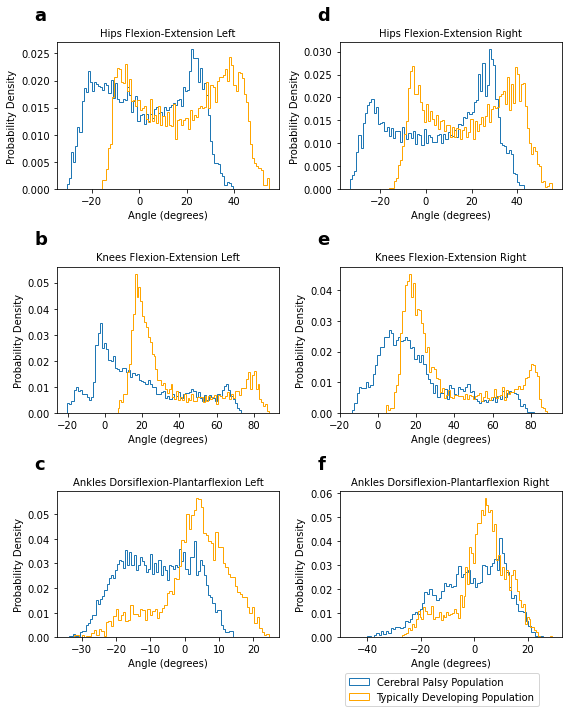

In [75]:
fig, axs = plt.subplots(nrows=3, ncols=2, tight_layout=True, figsize=(8,10))


plt.rcParams['font.size']=10
n = [[0,0], [1,0], [2,0], [0,1], [1,1], [2,1]] #indicies for the plots
alpha = ['a', 'b', 'c', 'd', 'e', 'f'] 
text_size=10

# fig.suptitle("Cerebral Palsy", fontsize=16)
for f in range(6):
    axs[n[f][0],n[f][1]].hist(X_CP_lt_data[:,:,f].reshape(-1,1), label= 'Cerebral Palsy Population', bins=80, density=True, histtype='step', )
    axs[n[f][0],n[f][1]].hist(X_train_data[:,:,f].reshape(-1,1), label='Typically Developing Population',bins=80, color='orange', density=True, histtype='step')
    # axs[n[f][0],n[f][1]].hist(X_CP_lt_data[:,:,f].reshape(-1,1), label= 'Cerebral Palsy Population', bins=80, density=False, histtype='step', )
    # axs[n[f][0],n[f][1]].hist(X_train_data[:,:,f].reshape(-1,1), label='Typically Developing Population',bins=80, color='orange', density=False, histtype='step')
    # axs[n[f][0],n[f][1]].axvline(X_train_data[:,:,f].min(), color='k', linestyle='dashed', linewidth=1, label='min/max')
    # axs[n[f][0],n[f][1]].axvline(X_train_data[:,:,f].max(), color='k', linestyle='dashed', linewidth=1)
    # axs[n[f][0],n[f][1]].axvline(X_CP_lt_data[:,:,f].min(), color='r', linestyle='dashed', linewidth=1)
    # axs[n[f][0],n[f][1]].axvline(X_CP_lt_data[:,:,f].max(), color='r', linestyle='dashed', linewidth=1)

    axs[n[f][0],n[f][1]].set_title(features[f])
    axs[n[f][0],n[f][1]].set_xlabel('Angle (degrees)', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Probability Density', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)
    axs[n[f][0],n[f][1]].text(-0.1, 1.15, alpha[f], size=18, weight='bold', transform=axs[n[f][0],n[f][1]].transAxes)


# axLine, axLabel = axs.get_legend_handles_labels()
plt.legend(loc='lower left', bbox_to_anchor=(0,-0.5))
    
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()

In [76]:
# Convert to Tensor 
# do not store on GPU (yet)
X_train = torch.from_numpy(X_train_norm).to(torch.float64)
Y_train = torch.from_numpy(Y_train_norm).to(torch.float64)

# X_val = torch.from_numpy(X_val_norm).float()

# X_val_resized = np.expand_dims(Y_val_norm[:,0,:], axis=1)
# Y_val = torch.from_numpy(X_val_resized).float()

X_val = torch.from_numpy(X_val_norm).to(torch.float64)
Y_val = torch.from_numpy(Y_val_norm).to(torch.float64)


X_val_lt = torch.from_numpy(X_val_lt_norm).to(torch.float64)
Y_val_lt = torch.from_numpy(Y_val_lt_norm).to(torch.float64)

X_test = torch.from_numpy(X_test_norm).to(torch.float64)
Y_test = torch.from_numpy(Y_test_norm).to(torch.float64)


X_test_lt = torch.from_numpy(X_test_lt_norm).to(torch.float64)
Y_test_lt = torch.from_numpy(Y_test_lt_norm).to(torch.float64)

X_CP_lt = torch.from_numpy(X_CP_lt_norm).to(torch.float64)
Y_CP_lt = torch.from_numpy(Y_CP_lt_norm).to(torch.float64)



print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')

print(f'X_val_lt shape: {X_val_lt.shape}') #long term predictions
print(f'Y_val_lt shape: {Y_val_lt.shape}') #long term predictions

print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')

print(f'X_test_lt shape: {X_test_lt.shape}') #long term predictions
print(f'Y_test_lt shape: {Y_test_lt.shape}') #long term predictions


print(f'X_CP_lt shape: {X_CP_lt.shape}') #long term predictions
print(f'Y_CP_lt shape: {Y_CP_lt.shape}') #long term predictions




X_train shape: torch.Size([3262, 100, 6])
Y_train shape: torch.Size([3262, 1, 6])
X_val shape: torch.Size([2907, 100, 6])
Y_val shape: torch.Size([2907, 1, 6])
X_val_lt shape: torch.Size([1174, 100, 6])
Y_val_lt shape: torch.Size([1174, 200, 6])
X_test shape: torch.Size([4832, 100, 6])
Y_test shape: torch.Size([4832, 1, 6])
X_test_lt shape: torch.Size([3041, 100, 6])
Y_test_lt shape: torch.Size([3041, 200, 6])
X_CP_lt shape: torch.Size([3215, 100, 6])
Y_CP_lt shape: torch.Size([3215, 200, 6])


In [77]:
X_val.dtype

torch.float64

In [78]:
train_dataset = gaitDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle = True)
# train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle = False) #256

val_dataset = gaitDataset(X_val, Y_val) #ADJUSTED
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=len(train_dataset), shuffle=False)


val_lt_dataset = gaitDataset(X_val_lt, Y_val_lt) #long term predictions
val_lt_dataloader = DataLoader(val_lt_dataset, batch_size=32, shuffle=True)

test_dataset = gaitDataset(X_test, Y_test) #ADJUSTED
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

test_lt_dataset = gaitDataset(X_test_lt, Y_test_lt) #long term predictions
test_lt_dataloader = DataLoader(test_lt_dataset, batch_size=32, shuffle=True)

CP_lt_dataset = gaitDataset(X_CP_lt, Y_CP_lt) #long term predictions
CP_lt_dataloader = DataLoader(CP_lt_dataset, batch_size=32, shuffle=True)


print(f"Train Dataset length: {len(train_dataset)}")
print(f"Val Dataset length: {len(val_dataset)}")
print(f"Val_lt Dataset length: {len(val_lt_dataset)}")
print(f"test Dataset length: {len(test_dataset)}")
print(f"test_lt Dataset length: {len(test_lt_dataset)}")

print(f"CP_lt Dataset length: {len(CP_lt_dataset)}")


Train Dataset length: 3262
Val Dataset length: 2907
Val_lt Dataset length: 1174
test Dataset length: 4832
test_lt Dataset length: 3041
CP_lt Dataset length: 3215


### Model training


In [79]:
print(f'shape of X_train: {X_train.shape}, shape of Y_train: {Y_train.shape}')

shape of X_train: torch.Size([3262, 100, 6]), shape of Y_train: torch.Size([3262, 1, 6])


In [80]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe.requires_grad = False
        #pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        #x = x + self.pe[:x.size(0), :]#Variable(self.pe[:x.size(0), :], requires_grad=False)
        x = x + self.pe[:x.size(1), :].unsqueeze(0).repeat(x.size(0), 1, 1) ## modified by Bing to adapt to batch
        return self.dropout(x)

In [86]:
class LSTM(nn.Module):
    def __init__(self, n_neurons, look_back):
        super(LSTM, self).__init__()

        self.input_size = len(features)
        self.hidden_size = 100
        self.num_layers = 2
        self.in_seq_len = look_back
        self.output_size = len(features)
        self.out_seq_len = output_window
        self.device = DEVICE
        
        # nn.LSTM(features, hidden_size, number of layers)
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first = True)

        #nn.fc1
        self.fc1 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))
        # self.fc1 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))


    def forward(self, input_data):

        # initialise hidden and cell states after passing through each batch (this is skipped in stateless model)
        h_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).double().to(self.device) # input_data.shape[0] is equal to batch size
        c_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).double().to(self.device)

        #propagate through LSTM
        lstm_out, (h_out, c_out) = self.lstm(input_data, (h_0, c_0))
        # print(f'shape h_out[-1] {h_out.shape}')
        # propagate through linear layer 
        fc1_out = self.fc1(h_out[-1])
       
        preds = fc1_out.reshape(input_data.shape[0], self.out_seq_len, self.output_size)
        # print(f'preds.shape (after reshaping): {preds.shape}')
        
        return preds

In [87]:
class MLP(nn.Module):
    def __init__(self, n_neurons, input_shape):
        super(MLP, self).__init__()
        # self.flatten = nn.Flatten()
        self.input_size = len(features)
        self.output_size = len(features)
        self.in_seq_len = input_shape
        self.out_seq_len = 1
        self.device = DEVICE 
        self.layers = 3
        self.num_units = 200
        

        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

        # self.MLP = nn.Sequential(
        #     nn.Linear(in_features=self.input_size*self.in_seq_len , out_features=200),
        #     nn.ReLU(),
        #     nn.Linear(200, 200),
        #     nn.ReLU(),
        #     nn.Linear(200, 200),
        #     nn.ReLU(),
        #     nn.Linear(200, self.output_size*self.out_seq_len),
        # )

        linear_layers_lst = [] #linear layer list
 
        for i in range(self.layers):
            linear_layers_lst.append(nn.Linear(self.num_units, self.num_units))
            linear_layers_lst.append(nn.ReLU())

       
        linear_layers = tuple((linear_layers_lst))

        self.MLP = nn.Sequential(nn.Linear(in_features=self.input_size*self.in_seq_len, out_features=self.num_units), 
                                nn.ReLU(), 
                                *linear_layers, 
                                nn.Linear(self.num_units, self.output_size*self.out_seq_len))

        # self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # print(f'shape of x: {x.shape}')
        out = self.flatten(x)
        # x is in the shape [batch_size, in_seq_len, features], but should be reshaped to [batch_size, in_seq_len*features]
        # print(f'shape of flatten: {out.shape}')
        out = self.MLP(out)
        # print(f'shape of MLP: {out.shape}')
        out = self.sigmoid(out)
        preds = out.reshape(x.shape[0],  self.out_seq_len,self.output_size)
        return preds

In [88]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
   
        self.input_size = len(features)
        self.output_size = len(features)
        # self.kernel_size = kernel_size
        # self.stride = stride
        self.device = DEVICE 
        self.in_seq_len = input_window
        self.out_seq_len = output_window
        self.conv1_channels = 32
        self.conv2_channels = 48
        self.conv3_channels = 256
        self.conv4_channels = 256
        self.kernel_12 = 3
        self.kernel_34 = 3
        self.padding = 2
        self.stride = 2
        self.dilation = 1

        def calc_shape(input, kernel_size, stride, padding=0, dilation =1, operation = 'conv'):
            if operation == 'conv':
            # size = ((input - kernel_size + (2 * padding))/stride)  + 1 
                size = ((input + 2 * padding - dilation * (kernel_size-1) -1)/stride )+ 1

            if operation == 'pool':
                size = ((input - kernel_size)/stride)  + 1

            return size

        self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = self.conv1_channels, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding, dilation=self.dilation)
        post_conv1 = calc_shape(input = self.in_seq_len, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv1: {post_conv1}')

        self.conv2 = nn.Conv1d(in_channels = self.conv1_channels, out_channels = self.conv2_channels, kernel_size = self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv2 = calc_shape(input = post_conv1, kernel_size =self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation,  operation='conv')
        # print(f'post conv2: {post_conv2}')

        self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool1 = calc_shape(input = post_conv2, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post poo1: {post_pool1}')

        self.conv3 = nn.Conv1d(in_channels=self.conv2_channels, out_channels=self.conv3_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation )
        post_conv3 = calc_shape(input = post_pool1, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding, dilation=self.dilation, operation='conv')
        # print(f'post conv3: {post_conv3}')


        self.conv4 = nn.Conv1d(in_channels=self.conv3_channels, out_channels=self.conv4_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv4 = calc_shape(input = post_conv3, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')
        # print(f'post conv4: {post_conv4}')


        self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool2 = calc_shape(input = post_conv4, kernel_size = 2, stride = 2,  operation='pool')
        # print(f'post pool2: {post_pool2}')

        # print(f'linear input: {post_pool2 * 32}')

        self.fc1 = nn.Linear(in_features = (int(post_pool2) * self.conv4_channels), out_features=(self.output_size * self.out_seq_len))
        #nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))


    def forward(self, input_data):
        
        input = input_data.permute(0,2,1)
        out = self.conv1(input)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        # print(f'conv1 out shape = {out.shape}') #conv1_out.shape = torch.Size([512, 12, 120])
        out = self.pool1(out)
        # print(f'pool1 out shape = {out.shape}')
        out = self.conv3(out)
        # print(f'conv2 out shape: {out.shape}')
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
        # print(f'flatten layer out shape: {out.shape}') #([512, 720]) 
        out = self.fc1(out)
        # print(f'fc1 out shape: {out.shape}')
        preds = out.reshape(input_data.shape[0],  self.out_seq_len, self.output_size)
        # print(f'preds.shape (after reshaping): {preds.shape}')

        return preds

In [89]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()

        # self.device = device
        self.feature_size = len(features)
        # self.out_seq_len = 6
        self.d_model= 80


        # self.t2v = Time2Vec(input_dim=len(features), embed_dim=self.d_model, act_function=torch.sin).to(DEVICE)
        self.enc_in = nn.Linear(len(features), self.d_model)
        self.dec_in = nn.Linear(len(features), self.d_model)
        self.pe = PositionalEncoding(d_model = self.d_model, dropout = 0.2).to(DEVICE)
        self.transformer = nn.Transformer(d_model=self.d_model, nhead = 8, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=100, dropout=0.1, batch_first=True)
        self.linear = nn.Linear(80 ,len(features))
        # self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        # print(f'input shape: {x.shape}')
        src = self.enc_in(x)
        src = self.pe(src)


        # print(f'after positional encoding: {out.shape}')

        # tgt = self.pe(x[:,:-1,:])
        # tgt = self.pe(x[:,-1,:].unsqueeze(1))
        tgt = self.dec_in(x[:,-1,:].unsqueeze(1))
        tgt = self.pe(tgt)

        out = self.transformer(src, tgt)
        # output of decoder shape: torch.Size([batch_size, 99, input_embed])
        # print(f'output of transfoermer: {out.shape}')
        
        out = out.reshape(out.shape[0], -1)
        # print(f'reshaped transfoer out: {out.shape}')

        out = self.linear(out)
        out = self.sigmoid(out)
        out = out.reshape(x.shape[0], 1, self.feature_size)
        # print(f'output of decoder shape: {out.shape}')

        
        return out

In [95]:
# DEVICE = 'cpu'
DEVICE = 'cuda'

In [96]:
n_neurons = 100
look_back = 100
model = MLP(n_neurons, look_back).double().to(DEVICE)
# model = LSTM(n_neurons, look_back).double().to(DEVICE)

# model = Transformer().double().to(DEVICE)
# model = CNN().double().to(DEVICE)


### Load Model from checkpoint

In [97]:

path = r'C:\Users\Rania\rbk9\git-hub\CP-gait-prediction\trained-models\FCN.pth'
# path = r'D:\Study 2 Results and Models\Study 2 Experiments\Exp079_221103_FCN_wide_norm' + '\\' + 'Exp079_221103_FCN_wide_norm.pth'


# path = r'D:\Study 2 Results and Models\Study 2 Experiments\Exp083_221103_CNN_wide_norm' + '\\' + 'Exp083_221103_CNN_wide_norm.pth'

In [98]:
#load model 
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint(path)

### Assessing Stability in the Presence of Guassian noise  

In [99]:
### Calculating long term MSE (with noise)
test_lt_dataloader = DataLoader(test_lt_dataset, batch_size=256, shuffle=False)

# loss_function = nn.MSELoss()
std_vals=[0.00, 0.01, 0.02, 0.03, 0.04, 0.05]
model.eval()
for std_val in std_vals:
    with torch.no_grad():
        mse_loss_total = 0.
        mse_std_total = 0.
        mae_loss_total = 0.
        mae_std_total = 0.

        for idx, (batch_inputs, batch_targets) in enumerate(test_lt_dataloader):

            extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
            
            current_inputs = batch_inputs

            for i in range(200):
                predictions = model(current_inputs)

                preds_with_noise = torch.normal(mean=predictions,std=std_val)

                extrapolation[:,i,:] = preds_with_noise.squeeze(1)

                current_inputs = torch.cat((current_inputs[:,1:,:], preds_with_noise), axis=1)

            # loss = loss_function(extrapolation, batch_targets)

            # input = denormalise(batch_inputs.cpu().numpy(), scalars)
            preds = denormalise(extrapolation.cpu().numpy(), scalars)
            actual  = denormalise(batch_targets.cpu().numpy(), scalars)

            r_mse_loss, r_mse_std = mse_loss(preds, actual, reduction='mean', format='np')
            r_mae_loss, r_mae_std = mae_loss(preds, actual, reduction='mean', format='np')

            # print(f'test MSE Loss: {r_mse_loss:.5}, test MSE std: {r_mse_std:.5}')
            # print(f'test MAE Loss: {r_mae_loss:.5}, test MAE std: {r_mae_std:.5}')

            mse_loss_total += r_mse_loss
            mse_std_total += r_mse_std
            mae_loss_total += r_mae_loss
            mae_std_total += r_mae_std

        
        mse_loss_total = mse_loss_total / len(test_lt_dataloader)
        mse_std_total = mse_std_total / len(test_lt_dataloader)
        mae_loss_total = mae_loss_total / len(test_lt_dataloader)
        mae_std_total = mae_std_total / len(test_lt_dataloader)
        
        print(f'Average test values for error value of {std_val}: --------------------------')
        print(f'test MSE Loss: {mse_loss_total:.5}, test MSE std: {mse_std_total:.5}')
        print(f'test MAE Loss: {mae_loss_total:.5}, test MAE std: {mae_std_total:.5}')
        print('-----------------------------------------------------------------')

Average test values for error value of 0.0: --------------------------
test MSE Loss: 127.5, test MSE std: 275.35
test MAE Loss: 8.1843, test MAE std: 7.6314
-----------------------------------------------------------------
Average test values for error value of 0.01: --------------------------
test MSE Loss: 145.65, test MSE std: 311.97
test MAE Loss: 8.7665, test MAE std: 8.198
-----------------------------------------------------------------
Average test values for error value of 0.02: --------------------------
test MSE Loss: 194.44, test MSE std: 395.33
test MAE Loss: 10.22, test MAE std: 9.421
-----------------------------------------------------------------
Average test values for error value of 0.03: --------------------------
test MSE Loss: 265.2, test MSE std: 502.2
test MAE Loss: 12.086, test MAE std: 10.88
-----------------------------------------------------------------
Average test values for error value of 0.04: --------------------------
test MSE Loss: 343.51, test MSE 

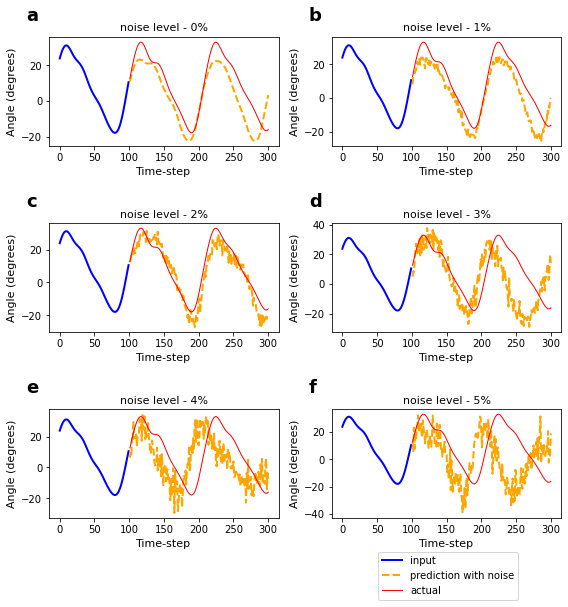

In [100]:
### Calculating long term MSE (with noise)
s=1060
sample_input = X_test_lt[s,:,:].unsqueeze(0).to(DEVICE)
sample_actual = Y_test_lt[s,:,:].unsqueeze(0).to(DEVICE)

# loss_function = nn.MSELoss()
std_vals=[0.00, 0.01, 0.02, 0.03, 0.04,0.05]
model.eval()
extrapolation_noise = torch.zeros((len(std_vals), 200, len(features))).to(DEVICE)

for m, std_val in enumerate(std_vals):
    with torch.no_grad():
          
        current_inputs = sample_input

        for i in range(200):
            predictions = model(current_inputs)

            preds_with_noise = torch.normal(mean=predictions,std=std_val)

            extrapolation_noise[m,i,:] = preds_with_noise.squeeze(1)

            current_inputs = torch.cat((current_inputs[:,1:,:], preds_with_noise), axis=1)

        # loss = loss_function(extrapolation, batch_targets)

        input_denorm = denormalise(sample_input.cpu().numpy(), scalars)
        extrapolation_denorm = denormalise(extrapolation_noise.cpu().numpy(), scalars)
        actual_denorm  = denormalise(sample_actual.cpu().numpy(), scalars)

x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)

fig, axs = plt.subplots(nrows=3, ncols=2, tight_layout=True, figsize=(8,9))
n = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1]] #indicies for the plots
alpha = ['a', 'b', 'c', 'd', 'e', 'f']
std_percent = ['0%', '1%', '2%', '3%', '4%', '5%']


text_size = 11
for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, input_denorm[0,:,0], lw=2, c='blue', label='input')
    axs[n[f][0],n[f][1]].plot(x3, extrapolation_denorm[f,:,0], lw=2, linestyle='dashed', c='orange', label='prediction with noise')
    axs[n[f][0],n[f][1]].plot(x3, actual_denorm[0,:,0], lw=1, c='r', label='actual')
    axs[n[f][0],n[f][1]].set_xlabel('Time-step', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (degrees)', size=text_size)
    axs[n[f][0],n[f][1]].set_title('noise level - ' + str(std_percent[f]), size=text_size)
    axs[n[f][0],n[f][1]].text(-0.1, 1.15, alpha[f], size=18, weight='bold', transform=axs[n[f][0],n[f][1]].transAxes)

    # if f==4:
    #     axs[n[f][0],n[f][1]].legend(loc='lower center', bbox_to_anchor=(0.5, -0.8))


# plt.legend()
plt.legend(loc='lower left', bbox_to_anchor=(0.18, -0.8))

In [101]:
### Calculating long term MSE (with noise)
CP_lt_dataloader = DataLoader(CP_lt_dataset, batch_size=256, shuffle=False)

# loss_function = nn.MSELoss()
std_vals=[0.00, 0.01, 0.02, 0.03, 0.04, 0.05]
model.eval()
for std_val in std_vals:
    with torch.no_grad():
        mse_loss_total = 0.
        mse_std_total = 0.
        mae_loss_total = 0.
        mae_std_total = 0.

        for idx, (batch_inputs, batch_targets) in enumerate(CP_lt_dataloader):

            extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
            
            current_inputs = batch_inputs

            for i in range(200):
                predictions = model(current_inputs)

                preds_with_noise = torch.normal(mean=predictions,std=std_val)

                extrapolation[:,i,:] = preds_with_noise.squeeze(1)

                current_inputs = torch.cat((current_inputs[:,1:,:], preds_with_noise), axis=1)

            # loss = loss_function(extrapolation, batch_targets)

            # input = denormalise(batch_inputs.cpu().numpy(), scalars)
            preds = denormalise(extrapolation.cpu().numpy(), scalars)
            actual  = denormalise(batch_targets.cpu().numpy(), scalars)

            r_mse_loss, r_mse_std = mse_loss(preds, actual, reduction='mean', format='np')
            r_mae_loss, r_mae_std = mae_loss(preds, actual, reduction='mean', format='np')

            # print(f'test MSE Loss: {r_mse_loss:.5}, test MSE std: {r_mse_std:.5}')
            # print(f'test MAE Loss: {r_mae_loss:.5}, test MAE std: {r_mae_std:.5}')

            mse_loss_total += r_mse_loss
            mse_std_total += r_mse_std
            mae_loss_total += r_mae_loss
            mae_std_total += r_mae_std

        
        mse_loss_total = mse_loss_total / len(CP_lt_dataloader)
        mse_std_total = mse_std_total / len(CP_lt_dataloader)
        mae_loss_total = mae_loss_total / len(CP_lt_dataloader)
        mae_std_total = mae_std_total / len(CP_lt_dataloader)
        
        print(f'Average test values for error value of {std_val}: --------------------------')
        print(f'CP MSE Loss: {mse_loss_total:.5}, CP MSE std: {mse_std_total:.5}')
        print(f'CP MAE Loss: {mae_loss_total:.5}, CP MAE std: {mae_std_total:.5}')
        print('-----------------------------------------------------------------')

Average test values for error value of 0.0: --------------------------
CP MSE Loss: 269.19, CP MSE std: 443.81
CP MAE Loss: 12.512, CP MAE std: 10.491
-----------------------------------------------------------------
Average test values for error value of 0.01: --------------------------
CP MSE Loss: 278.7, CP MSE std: 460.68
CP MAE Loss: 12.75, CP MAE std: 10.673
-----------------------------------------------------------------
Average test values for error value of 0.02: --------------------------
CP MSE Loss: 304.83, CP MSE std: 507.25
CP MAE Loss: 13.369, CP MAE std: 11.151
-----------------------------------------------------------------
Average test values for error value of 0.03: --------------------------
CP MSE Loss: 349.19, CP MSE std: 579.08
CP MAE Loss: 14.368, CP MAE std: 11.909
-----------------------------------------------------------------
Average test values for error value of 0.04: --------------------------
CP MSE Loss: 417.34, CP MSE std: 685.48
CP MAE Loss: 15.75,

In [102]:
j=400

in_sample = X_test_lt[j].unsqueeze(0).to(DEVICE)
pred_noise = np.zeros((1,200,6)) 
actual = Y_test_lt[j].unsqueeze(0)
std_val = 0.0

extrapolation = torch.zeros((1, 200, len(features))).to(DEVICE)
current_inputs=in_sample
for i in range(200):
    
    predictions = model(current_inputs)
 
    means = predictions.squeeze()
    preds_with_noise = torch.normal(mean=means,std=std_val)
    extrapolation[:,i,:] = preds_with_noise
    current_inputs = torch.cat((current_inputs[:,1:,:], preds_with_noise.reshape(1,1,len(features))), axis=1)

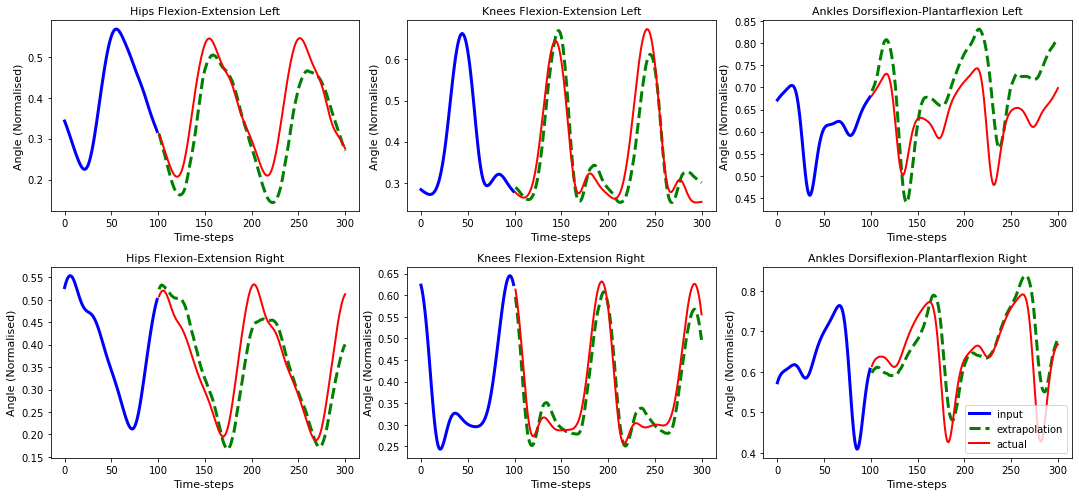

In [103]:
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)
# j=30

fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

text_size = 11
for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, in_sample[:,:,f].cpu().numpy().reshape(-1,1), lw=3, c='b', label='input')
    axs[n[f][0],n[f][1]].plot(x3, extrapolation[:,:,f].cpu().numpy().reshape(-1,1), lw=3, linestyle='dashed', c='g', label='extrapolation')
    axs[n[f][0],n[f][1]].plot(x3, actual[:,:,f].cpu().numpy().reshape(-1,1), lw=2, c='r', label='actual')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

plt.legend()

### Calculating DTW distances

In [106]:
### Calculating DTW for validation set

loss_function = nn.MSELoss()

model.eval()
with torch.no_grad():
    lt_loss_total = 0.
    dtw_total = 0.

    for idx, (batch_inputs, batch_targets) in enumerate(val_lt_dataloader):

        extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)

        batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
        current_inputs = batch_inputs
        for i in range(200):
            predictions = model(current_inputs)

            extrapolation[:,i,:] = predictions.squeeze(1)

            current_inputs = torch.cat((current_inputs[:,1:,:], predictions), axis=1)

        loss = loss_function(extrapolation, batch_targets)

        lt_loss_total += loss.item()

        #dtw
        running_dtw = 0.
        for s in range(batch_targets.shape[0]):
            for f in range(len(features)):
                dis = dtw(extrapolation[s,:,f].squeeze().cpu(),batch_targets[s,:,f].squeeze().cpu(), distance_only=True).distance
                
                running_dtw += dis

        dtw_total += running_dtw / (batch_targets.shape[0] * len(features))
    
    dtw_total = dtw_total / (len(val_lt_dataloader))

dtw_total

9.323909385246893

In [107]:
extrapolation.shape

torch.Size([22, 200, 6])

In [108]:
### Calculating DTW for test set
test_lt_dataloader = DataLoader(test_lt_dataset, batch_size=256, shuffle=False)

loss_function = nn.MSELoss()

model.eval()
with torch.no_grad():
    lt_loss_total = 0.
    dtw_total = 0.

    for idx, (batch_inputs, batch_targets) in enumerate(test_lt_dataloader):

        extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)

        batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
        current_inputs = batch_inputs
        for i in range(200):
            predictions = model(current_inputs)

            extrapolation[:,i,:] = predictions.squeeze(1)

            current_inputs = torch.cat((current_inputs[:,1:,:], predictions), axis=1)

        loss = loss_function(extrapolation, batch_targets)

        lt_loss_total += loss.item()

        #dtw
        running_dtw = 0.
        for s in range(batch_targets.shape[0]):
            for f in range(len(features)):
                dis = dtw(extrapolation[s,:,f].squeeze().cpu(),batch_targets[s,:,f].squeeze().cpu(), distance_only=True).distance
                
                running_dtw += dis

        dtw_total += running_dtw / (batch_targets.shape[0] * len(features))
    
    dtw_total = dtw_total / (len(test_lt_dataloader))

dtw_total

4.816261127693852

In [109]:
### Calculating DTW for CP set
CP_lt_dataloader = DataLoader(CP_lt_dataset, batch_size=256, shuffle=False)

loss_function = nn.MSELoss()

model.eval()
with torch.no_grad():
    lt_loss_total = 0.
    dtw_total = 0.

    for idx, (batch_inputs, batch_targets) in enumerate(CP_lt_dataloader):

        extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)

        batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
        current_inputs = batch_inputs
        for i in range(200):
            predictions = model(current_inputs)

            extrapolation[:,i,:] = predictions.squeeze(1)

            current_inputs = torch.cat((current_inputs[:,1:,:], predictions), axis=1)

        loss = loss_function(extrapolation, batch_targets)

        lt_loss_total += loss.item()

        #dtw
        running_dtw = 0.
        for s in range(batch_targets.shape[0]):
            for f in range(len(features)):
                dis = dtw(extrapolation[s,:,f].squeeze().cpu(),batch_targets[s,:,f].squeeze().cpu(), distance_only=True).distance
                
                running_dtw += dis

        dtw_total += running_dtw / (batch_targets.shape[0] * len(features))
    
    dtw_total = dtw_total / (len(CP_lt_dataloader))

dtw_total

10.760677725472757

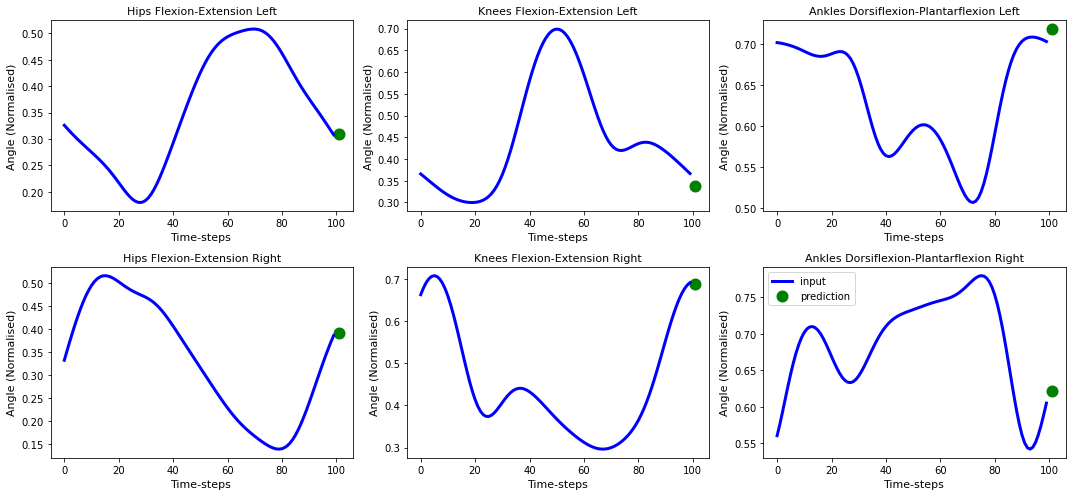

In [112]:
x1 = np.arange(0,100)
x2 = 101
s = 5

fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

text_size = 11

for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, batch_inputs[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label = 'input')
    axs[n[f][0],n[f][1]].scatter(x2, extrapolation[s,0,f].cpu().numpy(), lw=6, c='g', label='prediction')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

plt.legend()


In [126]:
# x1 = np.arange(0,100)
# x2 = 101
# x3 = np.arange(101,301)
# s=29
# fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
# n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

# text_size = 11
# for f in range(len(features)):
#     axs[n[f][0],n[f][1]].plot(x1, batch_inputs[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
#     axs[n[f][0],n[f][1]].plot(x3, extrapolation[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, linestyle='dashed', c='g', label='extrapolation')
#     axs[n[f][0],n[f][1]].plot(x3, batch_targets[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
#     axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
#     axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
#     axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

# plt.legend()

### Calculating One-step-ahead MSE and MAE

In [127]:
print(f'shape of X test data: {X_test.shape}, Y test data: {Y_test.shape}')

shape of X test data: torch.Size([4832, 100, 6]), Y test data: torch.Size([4832, 1, 6])


In [128]:
### Calculating one step ahead prediction for test set (for transformer only)
test_lt_dataloader = DataLoader(test_lt_dataset, batch_size=35, shuffle=False)

# loss_function = nn.MSELoss()

model.eval()
with torch.no_grad():
    mse_loss_total = 0.
    mse_std_total = 0.
    mae_loss_total = 0.
    mae_std_total = 0.

    for idx, (batch_inputs, batch_targets) in enumerate(test_lt_dataloader):

        extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)

        batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)     
   
        predictions = model(batch_inputs)

        # input = denormalise(batch_inputs.cpu().numpy(), scalars)
        actual = denormalise(predictions.cpu().numpy(), scalars)
        preds  = denormalise(batch_targets[:,0,:].unsqueeze(1).cpu().numpy(), scalars)

        r_mse_loss, r_mse_std = mse_loss(preds, actual, reduction='mean', format='np')
        r_mae_loss, r_mae_std = mae_loss(preds, actual, reduction='mean', format='np')

        # print(f'test MSE Loss: {r_mse_loss:.5}, test MSE std: {r_mse_std:.5}')
        # print(f'test MAE Loss: {r_mae_loss:.5}, test MAE std: {r_mae_std:.5}')

        mse_loss_total += r_mse_loss
        mse_std_total += r_mse_std
        mae_loss_total += r_mae_loss
        mae_std_total += r_mae_std

    
    mse_loss_total = mse_loss_total / len(test_lt_dataloader)
    mse_std_total = mse_std_total / len(test_lt_dataloader)
    mae_loss_total = mae_loss_total / len(test_lt_dataloader)
    mae_std_total = mae_std_total / len(test_lt_dataloader)
    
    print(f'Average test values: --------------------------')
    print(f'test MSE Loss: {mse_loss_total:.5}, test MSE std: {mse_std_total:.5}')
    print(f'test MAE Loss: {mae_loss_total:.5}, test MAE std: {mae_std_total:.5}')

Average test values: --------------------------
test MSE Loss: 2.9534, test MSE std: 3.8689
test MAE Loss: 1.3662, test MAE std: 1.0011


In [129]:
# Calculate predictions
model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(DEVICE))

#Denormalise X_val and Y_val and predictions 
input_test = denormalise(X_test.cpu().numpy(), scalars)
actual_test = denormalise(Y_test.cpu().numpy(), scalars)
preds_test = denormalise(test_predictions.cpu().numpy(), scalars)

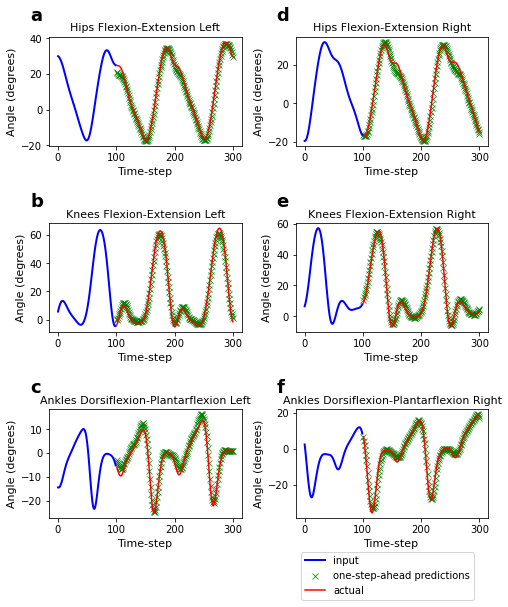

In [134]:
b=4

x3 = np.arange(101,301)
x1 = np.arange(0,100)
x2 = 104

fig, axs = plt.subplots(nrows=3, ncols=2, tight_layout=True, figsize=(7,9))
n = [[0,0], [1,0], [2,0], [0,1], [1,1], [2,1]] #indicies for the plots

text_size = 11
alpha = ['a', 'b', 'c', 'd', 'e', 'f']
for f in range(len(features)):
    # axs[n[f][0],n[f][1]].text(-0.1, 1, alpha[f], size=20, weight='bold', transform=axs[0,0].transAxes)
    axs[n[f][0],n[f][1]].plot(x1, input_test[b,:,f].reshape(-1,1).squeeze(), lw=2, c='b', label = 'input')
    axs[n[f][0],n[f][1]].scatter(x3, preds_test[b:b+200,:,f].reshape(-1,1).squeeze(), lw=0.7, marker = 'x', c='g', label='one-step-ahead predictions')
    # axs[n[f][0],n[f][1]].plot(x3, preds_test[b:b+200,:,f].reshape(-1,1).squeeze(), lw=2, linestyle = 'dashed', c='g', label='one-step-ahead predictions')

    axs[n[f][0],n[f][1]].plot(x3, actual_test[b:b+200,:,f].reshape(-1,1).squeeze(), lw=1.5, c='r', label='actual')

    axs[n[f][0],n[f][1]].set_xlabel('Time-step', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (degrees)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)
    axs[n[f][0],n[f][1]].text(-0.1, 1.15, alpha[f], size=18, weight='bold', transform=axs[n[f][0],n[f][1]].transAxes)


# axLine, axLabel = axs.get_legend_handles_labels()
plt.legend(loc='lower left', bbox_to_anchor=(-0,-0.8))

### Calculating long term loss

In [135]:
### Calculating long term MSE for test set
test_lt_dataloader = DataLoader(test_lt_dataset, batch_size=256, shuffle=False)


# loss_function = nn.MSELoss()

model.eval()
with torch.no_grad():
    mse_loss_total = 0.
    mse_std_total = 0.
    mae_loss_total = 0.
    mae_std_total = 0.

    for idx, (batch_inputs, batch_targets) in enumerate(test_lt_dataloader):

        extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)

        batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
        
        current_inputs = batch_inputs

        for i in range(200):
            predictions = model(current_inputs)

            extrapolation[:,i,:] = predictions.squeeze(1)

            current_inputs = torch.cat((current_inputs[:,1:,:], predictions), axis=1)

        # loss = loss_function(extrapolation, batch_targets)

        # input = denormalise(batch_inputs.cpu().numpy(), scalars)
        actual = denormalise(extrapolation.cpu().numpy(), scalars)
        preds  = denormalise(batch_targets.cpu().numpy(), scalars)

        r_mse_loss, r_mse_std = mse_loss(preds, actual, reduction='mean', format='np')
        r_mae_loss, r_mae_std = mae_loss(preds, actual, reduction='mean', format='np')

        # print(f'test MSE Loss: {r_mse_loss:.5}, test MSE std: {r_mse_std:.5}')
        # print(f'test MAE Loss: {r_mae_loss:.5}, test MAE std: {r_mae_std:.5}')

        mse_loss_total += r_mse_loss
        mse_std_total += r_mse_std
        mae_loss_total += r_mae_loss
        mae_std_total += r_mae_std

    
    mse_loss_total = mse_loss_total / len(test_lt_dataloader)
    mse_std_total = mse_std_total / len(test_lt_dataloader)
    mae_loss_total = mae_loss_total / len(test_lt_dataloader)
    mae_std_total = mae_std_total / len(test_lt_dataloader)
    
    print(f'Average test values: --------------------------')
    print(f'test MSE Loss: {mse_loss_total:.5}, test MSE std: {mse_std_total:.5}')
    print(f'test MAE Loss: {mae_loss_total:.5}, test MAE std: {mae_std_total:.5}')

Average test values: --------------------------
test MSE Loss: 127.5, test MSE std: 275.35
test MAE Loss: 8.1843, test MAE std: 7.6314


In [144]:
s=3 
sample_extrapolation = torch.zeros((1,200, len(features))).to(DEVICE)
sample_input = X_test_lt[s,:,:].unsqueeze(0).to(DEVICE)
sample_actual = Y_test_lt[s,:,:].unsqueeze(0).to(DEVICE)
current_sample_batch = sample_input

model.eval()
with torch.no_grad():
    for i in range(200):
        sample_preds = model(current_sample_batch)
        sample_extrapolation[:,i,:] = sample_preds
        current_sample_batch = torch.cat((current_sample_batch[:,1:,:], sample_preds), axis=1)

sample_preds.shape

torch.Size([1, 1, 6])

In [145]:
input_denorm = denormalise(sample_input.cpu().numpy(), scalars)
actual_denorm = denormalise(sample_actual.cpu().numpy(), scalars)
preds_denorm = denormalise(sample_extrapolation.cpu().numpy(), scalars)

input_denorm.shape
preds_denorm.shape

(1, 200, 6)

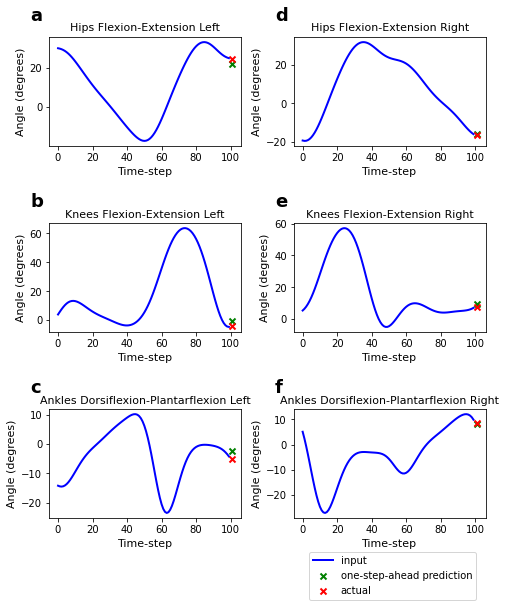

In [146]:
x1 = np.arange(0,100)
x2 = 101
s=5000 #sample used for paper

fig, axs = plt.subplots(nrows=3, ncols=2, tight_layout=True, figsize=(7,9))
n = [[0,0], [1,0], [2,0], [0,1], [1,1], [2,1]] #indicies for the plots

text_size = 11
alpha = ['a', 'b', 'c', 'd', 'e', 'f']
for f in range(len(features)):
    # axs[n[f][0],n[f][1]].text(-0.1, 1, alpha[f], size=20, weight='bold', transform=axs[0,0].transAxes)
    axs[n[f][0],n[f][1]].plot(x1, input_denorm[0,:,f], lw=2, c='b', label = 'input')
    axs[n[f][0],n[f][1]].scatter(x2, preds_denorm[0,0,f], lw=2, marker = 'x', c='g', label='one-step-ahead prediction')
    axs[n[f][0],n[f][1]].scatter(x2, actual_denorm[0,0,f], lw=2, marker = 'x', c='r', label='actual')

    axs[n[f][0],n[f][1]].set_xlabel('Time-step', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (degrees)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)
    axs[n[f][0],n[f][1]].text(-0.1, 1.15, alpha[f], size=18, weight='bold', transform=axs[n[f][0],n[f][1]].transAxes)


# axLine, axLabel = ax.get_legend_handles_labels()
plt.legend(loc='lower left', bbox_to_anchor=(0.05, -0.8))

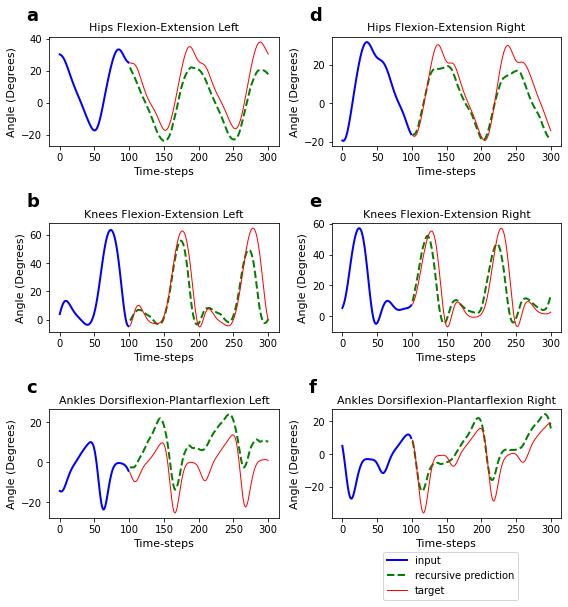

In [147]:
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)
s=6000 #sample for paper

fig, axs = plt.subplots(nrows=3, ncols=2, tight_layout=True, figsize=(8,9))
n = [[0,0], [1,0], [2,0], [0,1], [1,1], [2,1]] #indicies for the plots
alpha = ['a', 'b', 'c', 'd', 'e', 'f']

text_size = 11
for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, input_denorm[0,:,f], lw=2, c='b', label='input')
    axs[n[f][0],n[f][1]].plot(x3, preds_denorm[0,:,f], lw=2, linestyle='dashed', c='g', label='recursive prediction')
    axs[n[f][0],n[f][1]].plot(x3, actual_denorm[0,:,f], lw=1, c='r', label='target')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Degrees)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)
    axs[n[f][0],n[f][1]].text(-0.1, 1.15, alpha[f], size=18, weight='bold', transform=axs[n[f][0],n[f][1]].transAxes)


plt.legend(loc='lower left', bbox_to_anchor=(0.2, -0.8))

### Correcting CP Gait

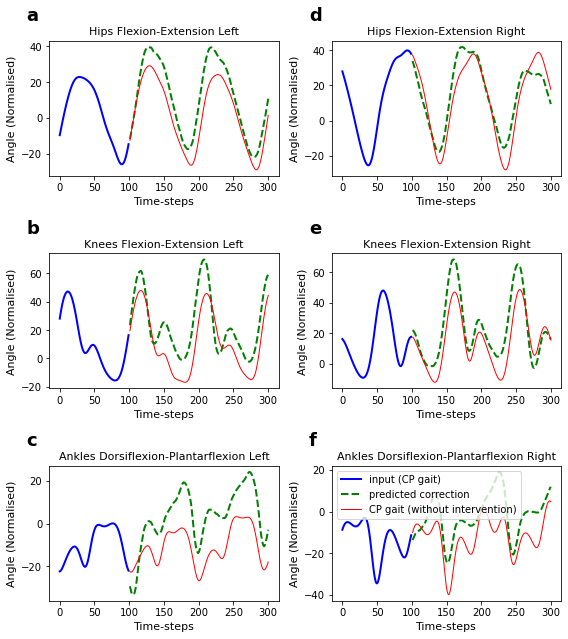

In [167]:
# s=20000
s=233

sample_extrapolation = torch.zeros((1,200, len(features))).to(DEVICE)
sample_input = X_CP_lt[s,:,:].unsqueeze(0).to(DEVICE)
sample_actual = Y_CP_lt[s,:,:].unsqueeze(0).to(DEVICE)
current_sample_batch = sample_input

model.eval()
with torch.no_grad():
    for i in range(200):
        sample_preds = model(current_sample_batch)
        sample_extrapolation[:,i,:] = sample_preds
        current_sample_batch = torch.cat((current_sample_batch[:,1:,:], sample_preds), axis=1)

input_denorm = denormalise(sample_input.cpu().numpy(), scalars)
actual_denorm = denormalise(sample_actual.cpu().numpy(), scalars)
preds_denorm = denormalise(sample_extrapolation.cpu().numpy(), scalars)

x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)

fig, axs = plt.subplots(nrows=3, ncols=2, tight_layout=True, figsize=(8,9))
n = [[0,0], [1,0], [2,0], [0,1], [1,1], [2,1]] #indicies for the plots
alpha = ['a', 'b', 'c', 'd', 'e', 'f']

text_size = 11
for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, input_denorm[0,:,f], lw=2, c='b', label='input (CP gait)')
    axs[n[f][0],n[f][1]].plot(x3, preds_denorm[0,:,f], lw=2, linestyle='dashed', c='g', label='predicted correction')
    axs[n[f][0],n[f][1]].plot(x3, actual_denorm[0,:,f], lw=1, c='r', label='CP gait (without intervention)')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)
    axs[n[f][0],n[f][1]].text(-0.1, 1.15, alpha[f], size=18, weight='bold', transform=axs[n[f][0],n[f][1]].transAxes)


plt.legend()
# plt.legend(loc=(0, -1))

## Locating Max and Min of gait patterns

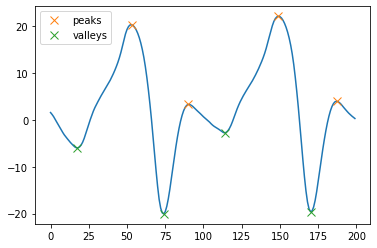

peaks are: [ 53  90 149 187]
peak 53: value 20.261756896972656
peak 90: value 3.2672805786132812
peak 149: value 22.06108856201172
peak 187: value 3.9438629150390625
valleys are: [ 17  74 114 170]
valley 17: value -5.9813690185546875
valley 74: value -20.067649841308594
valley 114: value -2.7841796875
valley 170: value -19.59765625


In [163]:
from scipy.signal import find_peaks
x=preds_denorm[0,:,2]
peaks, _ = find_peaks(x)
valleys,_ = find_peaks(x*-1)
plt.plot(x)
plt.plot(peaks, x[peaks], "x",markersize=8, label='peaks')
plt.plot(valleys,x[valleys],"x",markersize=8, label='valleys')
# plt.plot(np.zeros_like(x), "--", color="gray")
plt.legend()
plt.show()
print(f'peaks are: {peaks}')
for p in peaks:
    print(f'peak {p}: value {x[p]}')

print(f'valleys are: {valleys}')
for v in valleys:
    print(f'valley {v}: value {x[v]}')

In [162]:
print(f'shape of X test data: {X_CP_lt.shape}, Y test data: {Y_CP_lt.shape}')

shape of X test data: torch.Size([3215, 100, 6]), Y test data: torch.Size([3215, 200, 6])


In [163]:
# Calculate one-step-ahead prediction for CP
CP_lt_dataloader = DataLoader(CP_lt_dataset, batch_size=256, shuffle=False)

model.eval()
with torch.no_grad():
    CP_mse_loss = 0.
    CP_mse_std =0.
    CP_mae_loss=0.
    CP_mae_std=0. 

    for idx, (batch_inputs, batch_targets) in enumerate(CP_lt_dataloader):

        batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
        
        CP_predictions = model(batch_inputs)

        # input = denormalise(batch_inputs.cpu().numpy(), scalars)
        preds_CP = denormalise(CP_predictions.cpu().numpy(), scalars)
        actual_CP  = denormalise(batch_targets[:,0,:].unsqueeze(1).cpu().numpy(), scalars)

        r_mse_loss, r_mse_std = mse_loss(preds_CP, actual_CP, reduction='mean', format='np')
        r_mae_loss, r_mae_std = mae_loss(preds_CP, actual_CP, reduction='mean', format='np')

        # print(f'test MSE Loss: {r_mse_loss:.5}, test MSE std: {r_mse_std:.5}')
        # print(f'test MAE Loss: {r_mae_loss:.5}, test MAE std: {r_mae_std:.5}')

        CP_mse_loss += r_mse_loss
        CP_mse_std += r_mse_std
        CP_mae_loss += r_mae_loss
        CP_mae_std += r_mae_std

    
    CP_mse_loss = CP_mse_loss / len(CP_lt_dataloader)
    CP_mse_std = CP_mse_std / len(CP_lt_dataloader)
    CP_mae_loss = CP_mae_loss / len(CP_lt_dataloader)
    CP_mae_std = CP_mae_std / len(CP_lt_dataloader)
    
    print(f'Average CP values: --------------------------')
    print(f'CP MSE Loss: {CP_mse_loss:.5}, CP MSE std: {CP_mse_std:.5}')
    print(f'CP MAE Loss: {CP_mae_loss:.5}, CP MAE std: {CP_mae_std:.5}')

Average CP values: --------------------------
CP MSE Loss: 7.5469, CP MSE std: 11.827
CP MAE Loss: 2.1313, CP MAE std: 1.7193


### Calculating Long term loss

In [164]:
### Calculating long term MSE for test set
CP_lt_dataloader = DataLoader(CP_lt_dataset, batch_size=256, shuffle=False)

# loss_function = nn.MSELoss()

model.eval()
with torch.no_grad():
    mse_loss_total = 0.
    mse_std_total = 0.
    mae_loss_total = 0.
    mae_std_total = 0.

    for idx, (batch_inputs, batch_targets) in enumerate(CP_lt_dataloader):

        extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)

        batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
        
        current_inputs = batch_inputs

        for i in range(200):
            predictions = model(current_inputs)

            extrapolation[:,i,:] = predictions.squeeze(1)

            current_inputs = torch.cat((current_inputs[:,1:,:], predictions), axis=1)

        # loss = loss_function(extrapolation, batch_targets)

        # input = denormalise(batch_inputs.cpu().numpy(), scalars)
        actual = denormalise(extrapolation.cpu().numpy(), scalars)
        preds  = denormalise(batch_targets.cpu().numpy(), scalars)

        r_mse_loss, r_mse_std = mse_loss(preds, actual, reduction='mean', format='np')
        r_mae_loss, r_mae_std = mae_loss(preds, actual, reduction='mean', format='np')

        # print(f'test MSE Loss: {r_mse_loss:.5}, test MSE std: {r_mse_std:.5}')
        # print(f'test MAE Loss: {r_mae_loss:.5}, test MAE std: {r_mae_std:.5}')

        mse_loss_total += r_mse_loss
        mse_std_total += r_mse_std
        mae_loss_total += r_mae_loss
        mae_std_total += r_mae_std

    
    mse_loss_total = mse_loss_total / len(CP_lt_dataloader)
    mse_std_total = mse_std_total / len(CP_lt_dataloader)
    mae_loss_total = mae_loss_total / len(CP_lt_dataloader)
    mae_std_total = mae_std_total / len(CP_lt_dataloader)
    
    print(f'Average CP values: --------------------------')
    print(f'CP MSE Loss: {mse_loss_total:.5}, CP MSE std: {mse_std_total:.5}')
    print(f'CP MAE Loss: {mae_loss_total:.5}, CP MAE std: {mae_std_total:.5}')

Average CP values: --------------------------
CP MSE Loss: 269.19, CP MSE std: 443.81
CP MAE Loss: 12.512, CP MAE std: 10.491


### Calculating Naive Loss

In [165]:
## benchmark against naive output (making prediction using last value only)
naive_1_train_output = np.zeros(actual_test.shape)

    
for f in range(len(features)):
    for s in range(actual_test.shape[0]):
        naive_1_train_output[s,:,f] = np.ones((output_window)) * input_test[s,-1,f]

In [166]:
naive_1_mse_loss, naive_1_mse_std = mse_loss(naive_1_train_output, actual_test, reduction='mean', format='np')
naive_1_mae_loss, naive_1_mae_std = mae_loss(naive_1_train_output, actual_test, reduction='mean', format='np')

print(f'naive_1 MSE Loss: {naive_1_mse_loss}')
print(f'naive_1 MSE std: {naive_1_mse_std} ')
print(f'naive_1 MAE Loss: {naive_1_mae_loss}')
print(f'naive_1 MAE std: {naive_1_mae_std}')

naive_1 MSE Loss: 2.0714596787957604
naive_1 MSE std: 3.641625241115313 
naive_1 MAE Loss: 1.0561498129004345
naive_1 MAE std: 0.9777562331717131
